In [48]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import py7zr
import os
import torchvision
from torchvision import transforms
from PIL import Image
from efficientnet_pytorch import EfficientNet
from google.colab import drive
from torchvision.io import read_image
from torchvision.utils import make_grid


In [2]:
!pip install py7zr efficientnet_pytorch

In [36]:
! git clone https://github.com/kpomichowski/MoleDetector.git

fatal: destination path 'MoleDetector' already exists and is not an empty directory.


In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
MODEL_PATH = r'/content/MoleDetector/model_weights/EfficientNetB0_50_1656319902.pth'

In [31]:
with py7zr.SevenZipFile('/content/drive/MyDrive/Melanoma_data/CustomTestDataset.7z') as pzip:
  pzip.extractall(path='/content/')

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
def inference(image_path,model):
  img = Image.open(image_path)
  
  mean = [0.7636298672977316, 0.5460409399886097, 0.5704622818258704]
  std = [0.14052498579388373, 0.15315615440423488, 0.17051305095192615]

  transform_norm = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean, std)])
  # get normalized image
  img_normalized = transform_norm(img).float()
  img_normalized = img_normalized.unsqueeze_(0)
  img_normalized = img_normalized.to(device)

  with torch.no_grad():
    model.eval()  
    output = model(img_normalized)
    
    sm = torch.nn.Softmax(dim=1)
    probabilities = sm(output)
    probs = probabilities.detach().cpu().numpy().flatten()

    classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    predictions = [(np.round(prob * 100, 2), _class) for prob, _class in zip(probs, classes)]
    
    return sorted(predictions, key=lambda t: t[0], reverse=True)[:3]

In [ ]:
model = EfficientNet.from_name('efficientnet-b0', num_classes=7)
model.load_state_dict(torch.load(r'/content/MoleDetector/model_weights/EfficientNetB0_50_1656319902.pth', map_location=device))
model.to(device)

In [45]:
images = []
for image_name in os.listdir('./CustomTestDataset'):
  image = read_image(f'./CustomTestDataset/{image_name}')
  image = transforms.Resize((224, 224))(image)
  images.append(image)

In [51]:
grid = make_grid(images, nrow=2)

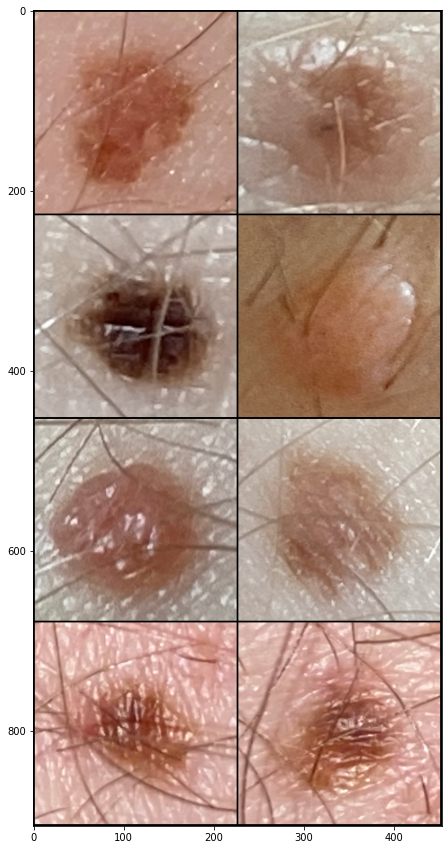

In [63]:
img = torchvision.transforms.ToPILImage()(grid)
plt.figure(figsize=(15, 15))
plt.imshow(img);

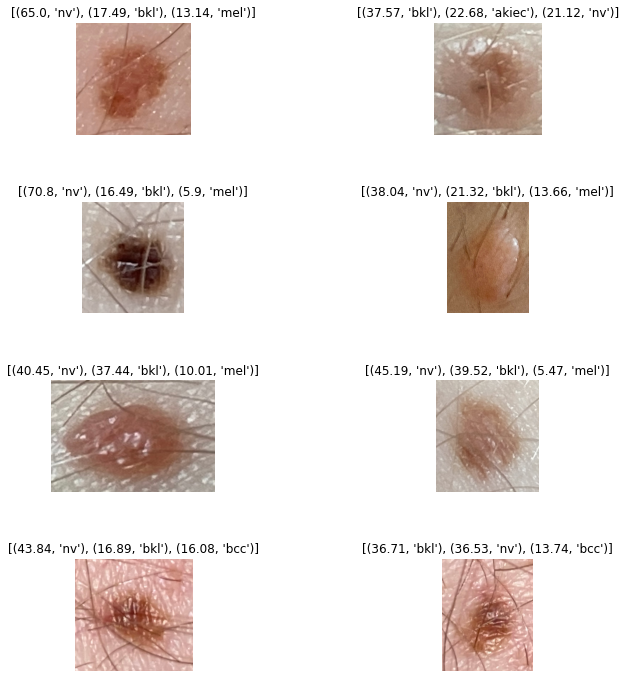

In [79]:

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
axs = axs.flatten()
for i, image_name in enumerate(os.listdir('./CustomTestDataset/')):
  score = inference(f'./CustomTestDataset/{image_name}', model)
  pic = plt.imread(f'./CustomTestDataset/{image_name}')  
  axs[i].imshow(pic)
  axs[i].set(title=score)
  axs[i].axis('off')
  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.6, 
                    hspace=0.6)
  